1.Preparations

In [1]:
import gc
from contextlib import nullcontext
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import numpy as np
import rich
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
def get_device(verbose: bool = False) -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        if verbose:
            print("Using GPU")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        if verbose:
            print("Using Apple Silicon GPU")
    else:
        device = torch.device("cpu")
        if verbose:
            print("Using CPU")
    return device


def clear_cuda():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()


def tensor_to_device(*tensors, device: torch.device = torch.device("cpu"), non_blocking=True):
    moved = tuple(t.to(device, non_blocking=non_blocking) for t in tensors)
    return moved if len(moved) > 1 else moved[0]


def print_color(text: str, color: str = "green"):
    rich.print(f"[{color}]{text}[/{color}]")


def get_ctx(use_mixed: bool, device: torch.device, amp_mode: str = "auto"):
    if not use_mixed or amp_mode == "off":
        print("Not using autocast context")
        return nullcontext()

    device_type = device.type

    if amp_mode == "fp16":
        dtype = torch.float16
    elif amp_mode == "bf16":
        dtype = torch.bfloat16
    else:
        if device_type == "cuda":
            dtype = torch.bfloat16
        elif device_type == "mps":
            dtype = torch.float16
        elif device_type == "cpu":
            dtype = torch.float16
        else:
            return nullcontext()

    print(f"Using autocast with dtype={dtype} on device type={device_type}")
    return torch.autocast(device_type=device_type, dtype=dtype)

2.Vision Transformer Model

2.1Model Config

In [3]:
@dataclass
class ModelConfig:
    image_size : int = 32
    patch_size:int = 4
    num_channels:int=3
    num_classes:int=10
    
    num_layers:int=6
    num_heads:int=8
    d_model:int =128
    d_ff:int = 512
    
    dropout_rate:float=0.1
    attention_dropout_rate:float=0.1

2.2Patch Embedding

In [4]:
class PatchEmbedder(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        self.config = config
        self.num_patches_per_side = config.image_size//config.patch_size
        self.num_patches = self.num_patches_per_side ** 2
        
        self.proj = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels= config.d_model,
            kernel_size=config.patch_size,
            stride=config.patch_size,
        )
    
    def forward(self, x:torch.Tensor):
        #x: (B,C,H,W)
        x = self.proj(x) # (B,D,H/P,W/P)
        x = x.flatten(2) #(B,D,N)
        x = x.transpose(1,2) #(B,N,D)
        
        return x
        

2.3Position Embedding

In [5]:
class PosEmbedder(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.position_embeddings = nn.Parameter(
            torch.randn(1, (config.image_size // config.patch_size) ** 2 + 1, config.d_model)
        )

        
        self.cls_token=nn. Parameter(torch.randn(1,1,config.d_model))
        
    def forward(self, x:torch.Tensor):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B,1,-1)
        x = torch.cat((cls_tokens,x),dim=1)
        
        x=x+self.position_embeddings
        
        return x

2.4MHA

In [6]:
class MHA(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.num_heads=config.num_heads
        self.d_model=config.d_model
        assert config.d_model % config.num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_k = config.d_model // config.num_heads
        self.qkv_linear = nn.Linear(config.d_model, config.d_model*3)
        self.out_linear = nn.Linear(config.d_model,config.d_model)
        
        self.attention_dropout = nn.Dropout(config.attention_dropout_rate)
    
    def forward(self,x: torch.Tensor):
        B,N,C = x.shape # Batch size, Number of tokens, Embedding dimension
        
        q,k,v=(
            self.qkv_linear(x).reshape(B,N,3,self.num_heads,self.d_k).permute(2,0,3,1,4).unbind(0)
        )
        
        scores = torch.matmul(q, k.transpose(-2,-1))/torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32)) # (B, num_heads, N, N)
        
        attn_weight = torch.softmax(scores,dim=-1)# (B, num_heads, N, N)
        attn = self.attention_dropout(attn_weight)
        
        context = torch.matmul(attn,v)# (B, num_heads, N, d_k)
        context = context.transpose(1,2).reshape(B,N,C)# (B, N, d_model)
        
        out =self.out_linear(context)# (B, N, d_model)
        
        return out, attn_weight
        

2.5FFN

In [7]:
class FFN(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        self.fc1 = nn.Linear(config.d_model,config.d_ff)
        self.fc2 = nn.Linear(config.d_ff,config.d_model)
        
        self.dropout = nn.Dropout(config.dropout_rate)
        
    def forward(self, x:torch.Tensor):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

2.6Layer Norm

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, in_dim:int, eps:float=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(in_dim))
        self.beta = nn.Parameter(torch.zeros(in_dim))
        
    def forward(self, x:torch.Tensor):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        
        x_hat = (x-mean)/torch.sqrt(var+self.eps)
        
        return self.gamma*x_hat+self.beta
        

2.7ViT Encoder

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.mha = MHA(config)
        self.ffn = FFN(config)
        
        self.norm1 = LayerNorm(config.d_model)
        self.norm2 = LayerNorm(config.d_model)
        
    def forward(self, x:torch.Tensor):
        attn, _ = self.mha(self.norm1(x))
        x = x + attn
        x = x + self.ffn(self.norm2(x))
        
        return x

2.8Classifier Head

In [10]:
class MLPHead(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.fc1 = nn.Linear(config.d_model, config.d_model)
        self.fc2 = nn.Linear(config.d_model, config.num_classes)
        self.dropout = nn.Dropout(config.dropout_rate)
        
    def forward(self, x:torch.Tensor):
        cls = x[:,0,:]
        cls = self.dropout(F.relu(self.fc1(cls)))
        cls = self.fc2(cls)
        
        return cls
        

2.9Full ViT Model

In [11]:
class Backbone(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        self.patch_embedder = PatchEmbedder(config)
        self.pos_embedder = PosEmbedder(config)
        self.encoder_layers = nn.ModuleList([EncoderBlock(config) for _ in range(config.num_layers)])
        
    def forward(self, x:torch.Tensor):
        x = self.patch_embedder(x)
        x = self.pos_embedder(x)
        for layer in self.encoder_layers:
            x = layer(x)
            
        return x

In [12]:
class ViT(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.backbone = Backbone(config)
        self.class_head = MLPHead(config)
        
    def forward(self,x :torch.Tensor):
        x = self.backbone(x)
        x = self.class_head(x)
        
        return x

2.10Dummy Test

In [13]:
DEVICE = get_device(verbose=True)
config = ModelConfig()
model = ViT(config).to(DEVICE)
dummy_input = torch.randn(2, config.num_channels, config.image_size, config.image_size).to(DEVICE)
dummy_output = model(dummy_input)

assert dummy_output.shape == (2, config.num_classes)

Using GPU


3.Training

3.1Training Config

In [15]:
@dataclass
class TrainConfig:
    num_epochs: int = 100
    eval_every_epoch: int = 5
    batch_size = 256
    debug: bool = True

    lr = 1e-4
    min_lr = 1e-5
    betas: tuple[float, float] = field(default_factory=lambda: (0.9, 0.99))
    weight_decay: float = 0.01

    data_dir: str = "./data"

    device: torch.device = get_device()
    use_mixed: bool = True

    def __post_init__(self):
        if self.debug:
            self.num_epochs = 4
            self.batch_size = 256


train_config = TrainConfig(debug=False)

3.2Load CIFAR-10 Dataset and Dataloader

In [16]:
IMG_MEAN = [0.4914, 0.4822, 0.4465]
IMG_STD = [0.2470, 0.2435, 0.2616]
IMG_SIZE = 32


data_transform = transforms.Compose(
    [
        transforms.Resize(
            (IMG_SIZE, IMG_SIZE),
            interpolation=transforms.InterpolationMode.BILINEAR,
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_STD),
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root=train_config.data_dir, download=True, train=True, transform=data_transform
)
if train_config.debug:
    train_dataset = torch.utils.data.Subset(train_dataset, range(1000))


dataloader = DataLoader(
    train_dataset,
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True if train_config.device.type == "cuda" else False,
)


100%|████████████████████████████████████████| 170M/170M [00:06<00:00, 26.2MB/s]


3.3Training Loop

In [17]:
model_config = ModelConfig()
model = ViT(model_config).to(train_config.device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=train_config.lr,
    betas=train_config.betas,
    weight_decay=train_config.weight_decay,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, train_config.num_epochs, eta_min=train_config.min_lr
)

ctx = get_ctx(use_mixed=train_config.use_mixed, device=train_config.device, amp_mode="auto")

Using autocast with dtype=torch.bfloat16 on device type=cuda


In [18]:
train_loss_per_step = []
train_acc_per_step = []


for epoch in range(train_config.num_epochs):
    # -------------------- Train --------------------
    model.train()
    batch_loss = 0.0
    batch_acc = 0.0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{train_config.num_epochs}")
    for images, labels in pbar:
        images, labels = tensor_to_device(images, labels, device=train_config.device)

        optimizer.zero_grad(set_to_none=True)
        with ctx:
            outputs = model(images)
            loss = criterion(outputs, labels)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        scheduler.step()

        # stats
        running_loss = loss.item()

        batch_size = images.size(0)

        # Calculate accuracy
        preds = outputs.argmax(dim=1)
        running_correct = (preds == labels).sum().item()
        running_correct /= labels.shape[0]

        train_loss_per_step.append(running_loss)
        train_acc_per_step.append(running_correct)
        batch_loss += running_loss
        batch_acc += running_correct

        pbar.set_postfix(loss=f"{running_loss:.4f}", acc=f"{running_correct:.4f}")

        del images, labels, outputs, loss
        clear_cuda()

    print_color(
        f"Train[{epoch + 1}/{train_config.num_epochs}]: loss: {batch_loss / len(dataloader):.4f} | acc: {batch_acc / len(dataloader):.4f} \n"
    )

Epoch 1/100: 100%|███| 196/196 [00:21<00:00,  9.10it/s, acc=0.1625, loss=2.1405]


Train[1/100]: loss: 2.1754 | acc: 0.1852 

Epoch 2/100: 100%|███| 196/196 [00:21<00:00,  9.04it/s, acc=0.2375, loss=2.1390]


Train[2/100]: loss: 2.0584 | acc: 0.2195 

Epoch 3/100: 100%|███| 196/196 [00:21<00:00,  8.93it/s, acc=0.2250, loss=2.0367]


Train[3/100]: loss: 2.0356 | acc: 0.2311 

Epoch 4/100: 100%|███| 196/196 [00:21<00:00,  9.00it/s, acc=0.2250, loss=2.0619]


Train[4/100]: loss: 2.0083 | acc: 0.2472 

Epoch 5/100: 100%|███| 196/196 [00:21<00:00,  9.17it/s, acc=0.2875, loss=1.8849]


Train[5/100]: loss: 1.9754 | acc: 0.2594 

Epoch 6/100: 100%|███| 196/196 [00:21<00:00,  8.92it/s, acc=0.3375, loss=1.8435]


Train[6/100]: loss: 1.9530 | acc: 0.2678 

Epoch 7/100: 100%|███| 196/196 [00:21<00:00,  9.07it/s, acc=0.3125, loss=1.8100]


Train[7/100]: loss: 1.9389 | acc: 0.2779 

Epoch 8/100: 100%|███| 196/196 [00:21<00:00,  9.00it/s, acc=0.2625, loss=1.9800]


Train[8/100]: loss: 1.9278 | acc: 0.2822 

Epoch 9/100: 100%|███| 196/196 [00:21<00:00,  9.01it/s, acc=0.2000, loss=2.0338]


Train[9/100]: loss: 1.9154 | acc: 0.2877 

Epoch 10/100: 100%|██| 196/196 [00:22<00:00,  8.89it/s, acc=0.2875, loss=1.8031]


Train[10/100]: loss: 1.9017 | acc: 0.2950 

Epoch 11/100: 100%|██| 196/196 [00:21<00:00,  9.04it/s, acc=0.2875, loss=1.7634]


Train[11/100]: loss: 1.8875 | acc: 0.2976 

Epoch 12/100: 100%|██| 196/196 [00:22<00:00,  8.90it/s, acc=0.3375, loss=1.8904]


Train[12/100]: loss: 1.8797 | acc: 0.3022 

Epoch 13/100: 100%|██| 196/196 [00:21<00:00,  9.04it/s, acc=0.4500, loss=1.6761]


Train[13/100]: loss: 1.8717 | acc: 0.3037 

Epoch 14/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.4250, loss=1.7441]


Train[14/100]: loss: 1.8651 | acc: 0.3100 

Epoch 15/100: 100%|██| 196/196 [00:22<00:00,  8.89it/s, acc=0.3750, loss=1.7248]


Train[15/100]: loss: 1.8620 | acc: 0.3102 

Epoch 16/100: 100%|██| 196/196 [00:22<00:00,  8.88it/s, acc=0.3375, loss=1.8560]


Train[16/100]: loss: 1.8536 | acc: 0.3117 

Epoch 17/100: 100%|██| 196/196 [00:22<00:00,  8.90it/s, acc=0.4250, loss=1.6632]


Train[17/100]: loss: 1.8510 | acc: 0.3140 

Epoch 18/100: 100%|██| 196/196 [00:22<00:00,  8.88it/s, acc=0.3250, loss=2.0109]


Train[18/100]: loss: 1.8489 | acc: 0.3143 

Epoch 19/100: 100%|██| 196/196 [00:21<00:00,  9.06it/s, acc=0.3625, loss=1.8160]


Train[19/100]: loss: 1.8413 | acc: 0.3184 

Epoch 20/100: 100%|██| 196/196 [00:21<00:00,  8.95it/s, acc=0.3375, loss=1.8051]


Train[20/100]: loss: 1.8384 | acc: 0.3190 

Epoch 21/100: 100%|██| 196/196 [00:21<00:00,  8.98it/s, acc=0.3625, loss=1.8020]


Train[21/100]: loss: 1.8360 | acc: 0.3190 

Epoch 22/100: 100%|██| 196/196 [00:21<00:00,  9.05it/s, acc=0.3875, loss=1.7151]


Train[22/100]: loss: 1.8303 | acc: 0.3214 

Epoch 23/100: 100%|██| 196/196 [00:21<00:00,  9.06it/s, acc=0.3875, loss=1.6663]


Train[23/100]: loss: 1.8284 | acc: 0.3228 

Epoch 24/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.3000, loss=1.8235]


Train[24/100]: loss: 1.8248 | acc: 0.3232 

Epoch 25/100: 100%|██| 196/196 [00:21<00:00,  8.92it/s, acc=0.4875, loss=1.6438]


Train[25/100]: loss: 1.8215 | acc: 0.3252 

Epoch 26/100: 100%|██| 196/196 [00:21<00:00,  8.91it/s, acc=0.3625, loss=1.7954]


Train[26/100]: loss: 1.8181 | acc: 0.3251 

Epoch 27/100: 100%|██| 196/196 [00:22<00:00,  8.86it/s, acc=0.4000, loss=1.6985]


Train[27/100]: loss: 1.8155 | acc: 0.3267 

Epoch 28/100: 100%|██| 196/196 [00:21<00:00,  8.99it/s, acc=0.3125, loss=1.8971]


Train[28/100]: loss: 1.8158 | acc: 0.3261 

Epoch 29/100: 100%|██| 196/196 [00:21<00:00,  9.07it/s, acc=0.3750, loss=1.8135]


Train[29/100]: loss: 1.8114 | acc: 0.3254 

Epoch 30/100: 100%|██| 196/196 [00:21<00:00,  9.03it/s, acc=0.2750, loss=1.8683]


Train[30/100]: loss: 1.8087 | acc: 0.3292 

Epoch 31/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.4750, loss=1.7871]


Train[31/100]: loss: 1.8058 | acc: 0.3321 

Epoch 32/100: 100%|██| 196/196 [00:21<00:00,  9.06it/s, acc=0.3375, loss=1.9544]


Train[32/100]: loss: 1.8034 | acc: 0.3308 

Epoch 33/100: 100%|██| 196/196 [00:22<00:00,  8.88it/s, acc=0.3250, loss=1.9143]


Train[33/100]: loss: 1.7999 | acc: 0.3320 

Epoch 34/100: 100%|██| 196/196 [00:21<00:00,  9.01it/s, acc=0.3125, loss=1.7479]


Train[34/100]: loss: 1.7969 | acc: 0.3298 

Epoch 35/100: 100%|██| 196/196 [00:21<00:00,  9.02it/s, acc=0.3625, loss=1.7087]


Train[35/100]: loss: 1.7919 | acc: 0.3336 

Epoch 36/100: 100%|██| 196/196 [00:21<00:00,  9.06it/s, acc=0.2875, loss=2.0027]


Train[36/100]: loss: 1.7903 | acc: 0.3330 

Epoch 37/100: 100%|██| 196/196 [00:21<00:00,  9.00it/s, acc=0.4000, loss=1.7824]


Train[37/100]: loss: 1.7876 | acc: 0.3341 

Epoch 38/100: 100%|██| 196/196 [00:21<00:00,  8.93it/s, acc=0.2875, loss=1.7596]


Train[38/100]: loss: 1.7842 | acc: 0.3335 

Epoch 39/100: 100%|██| 196/196 [00:21<00:00,  8.99it/s, acc=0.3375, loss=1.8030]


Train[39/100]: loss: 1.7808 | acc: 0.3345 

Epoch 40/100: 100%|██| 196/196 [00:21<00:00,  8.92it/s, acc=0.3750, loss=1.5638]


Train[40/100]: loss: 1.7756 | acc: 0.3376 

Epoch 41/100: 100%|██| 196/196 [00:21<00:00,  9.06it/s, acc=0.3125, loss=1.7432]


Train[41/100]: loss: 1.7749 | acc: 0.3363 

Epoch 42/100: 100%|██| 196/196 [00:21<00:00,  9.00it/s, acc=0.3250, loss=1.7828]


Train[42/100]: loss: 1.7732 | acc: 0.3370 

Epoch 43/100: 100%|██| 196/196 [00:21<00:00,  9.10it/s, acc=0.2250, loss=1.8550]


Train[43/100]: loss: 1.7718 | acc: 0.3360 

Epoch 44/100: 100%|██| 196/196 [00:21<00:00,  9.05it/s, acc=0.4000, loss=1.7952]


Train[44/100]: loss: 1.7683 | acc: 0.3386 

Epoch 45/100: 100%|██| 196/196 [00:22<00:00,  8.84it/s, acc=0.3000, loss=1.8501]


Train[45/100]: loss: 1.7673 | acc: 0.3376 

Epoch 46/100: 100%|██| 196/196 [00:21<00:00,  9.11it/s, acc=0.3500, loss=1.8125]


Train[46/100]: loss: 1.7655 | acc: 0.3397 

Epoch 47/100: 100%|██| 196/196 [00:21<00:00,  9.00it/s, acc=0.3250, loss=1.7876]


Train[47/100]: loss: 1.7631 | acc: 0.3373 

Epoch 48/100: 100%|██| 196/196 [00:21<00:00,  9.07it/s, acc=0.3000, loss=1.8012]


Train[48/100]: loss: 1.7615 | acc: 0.3384 

Epoch 49/100: 100%|██| 196/196 [00:21<00:00,  9.03it/s, acc=0.3625, loss=1.8979]


Train[49/100]: loss: 1.7605 | acc: 0.3401 

Epoch 50/100: 100%|██| 196/196 [00:21<00:00,  9.10it/s, acc=0.2750, loss=1.7294]


Train[50/100]: loss: 1.7591 | acc: 0.3410 

Epoch 51/100: 100%|██| 196/196 [00:21<00:00,  8.99it/s, acc=0.2500, loss=1.8258]


Train[51/100]: loss: 1.7589 | acc: 0.3411 

Epoch 52/100: 100%|██| 196/196 [00:21<00:00,  9.03it/s, acc=0.3875, loss=1.7439]


Train[52/100]: loss: 1.7595 | acc: 0.3397 

Epoch 53/100: 100%|██| 196/196 [00:21<00:00,  9.00it/s, acc=0.4500, loss=1.6375]


Train[53/100]: loss: 1.7588 | acc: 0.3391 

Epoch 54/100: 100%|██| 196/196 [00:21<00:00,  9.10it/s, acc=0.3125, loss=1.7821]


Train[54/100]: loss: 1.7562 | acc: 0.3407 

Epoch 55/100: 100%|██| 196/196 [00:21<00:00,  9.05it/s, acc=0.3750, loss=1.7033]


Train[55/100]: loss: 1.7572 | acc: 0.3407 

Epoch 56/100: 100%|██| 196/196 [00:21<00:00,  8.92it/s, acc=0.3500, loss=1.7884]


Train[56/100]: loss: 1.7561 | acc: 0.3406 

Epoch 57/100: 100%|██| 196/196 [00:21<00:00,  8.95it/s, acc=0.3125, loss=1.6924]


Train[57/100]: loss: 1.7554 | acc: 0.3431 

Epoch 58/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.3500, loss=1.7808]


Train[58/100]: loss: 1.7560 | acc: 0.3411 

Epoch 59/100: 100%|██| 196/196 [00:21<00:00,  8.93it/s, acc=0.3000, loss=1.9442]


Train[59/100]: loss: 1.7535 | acc: 0.3402 

Epoch 60/100: 100%|██| 196/196 [00:22<00:00,  8.82it/s, acc=0.3000, loss=1.8075]


Train[60/100]: loss: 1.7555 | acc: 0.3405 

Epoch 61/100: 100%|██| 196/196 [00:21<00:00,  8.92it/s, acc=0.3375, loss=1.7656]


Train[61/100]: loss: 1.7542 | acc: 0.3431 

Epoch 62/100: 100%|██| 196/196 [00:22<00:00,  8.86it/s, acc=0.4250, loss=1.7103]


Train[62/100]: loss: 1.7550 | acc: 0.3419 

Epoch 63/100: 100%|██| 196/196 [00:22<00:00,  8.90it/s, acc=0.4125, loss=1.6456]


Train[63/100]: loss: 1.7541 | acc: 0.3413 

Epoch 64/100: 100%|██| 196/196 [00:22<00:00,  8.82it/s, acc=0.3000, loss=1.8004]


Train[64/100]: loss: 1.7551 | acc: 0.3407 

Epoch 65/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.3250, loss=1.7989]


Train[65/100]: loss: 1.7532 | acc: 0.3419 

Epoch 66/100: 100%|██| 196/196 [00:21<00:00,  9.06it/s, acc=0.4125, loss=1.7079]


Train[66/100]: loss: 1.7544 | acc: 0.3401 

Epoch 67/100: 100%|██| 196/196 [00:21<00:00,  9.02it/s, acc=0.3250, loss=1.8577]


Train[67/100]: loss: 1.7555 | acc: 0.3407 

Epoch 68/100: 100%|██| 196/196 [00:21<00:00,  9.02it/s, acc=0.4125, loss=1.7058]


Train[68/100]: loss: 1.7544 | acc: 0.3415 

Epoch 69/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.3625, loss=1.6773]


Train[69/100]: loss: 1.7546 | acc: 0.3390 

Epoch 70/100: 100%|██| 196/196 [00:21<00:00,  8.93it/s, acc=0.2875, loss=1.7887]


Train[70/100]: loss: 1.7543 | acc: 0.3415 

Epoch 71/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.3375, loss=1.6984]


Train[71/100]: loss: 1.7540 | acc: 0.3409 

Epoch 72/100: 100%|██| 196/196 [00:21<00:00,  8.99it/s, acc=0.2500, loss=1.7935]


Train[72/100]: loss: 1.7585 | acc: 0.3398 

Epoch 73/100: 100%|██| 196/196 [00:21<00:00,  9.01it/s, acc=0.3125, loss=1.8476]


Train[73/100]: loss: 1.7557 | acc: 0.3387 

Epoch 74/100: 100%|██| 196/196 [00:22<00:00,  8.87it/s, acc=0.3875, loss=1.6811]


Train[74/100]: loss: 1.7539 | acc: 0.3399 

Epoch 75/100: 100%|██| 196/196 [00:21<00:00,  8.92it/s, acc=0.4500, loss=1.7126]


Train[75/100]: loss: 1.7556 | acc: 0.3415 

Epoch 76/100: 100%|██| 196/196 [00:21<00:00,  8.94it/s, acc=0.3125, loss=1.7885]


Train[76/100]: loss: 1.7571 | acc: 0.3411 

Epoch 77/100: 100%|██| 196/196 [00:21<00:00,  8.99it/s, acc=0.4125, loss=1.6180]


Train[77/100]: loss: 1.7562 | acc: 0.3419 

Epoch 78/100: 100%|██| 196/196 [00:21<00:00,  9.07it/s, acc=0.3500, loss=1.6755]


Train[78/100]: loss: 1.7581 | acc: 0.3415 

Epoch 79/100: 100%|██| 196/196 [00:21<00:00,  9.07it/s, acc=0.3500, loss=1.7792]


Train[79/100]: loss: 1.7584 | acc: 0.3413 

Epoch 80/100: 100%|██| 196/196 [00:21<00:00,  8.97it/s, acc=0.3375, loss=1.7399]


Train[80/100]: loss: 1.7561 | acc: 0.3417 

Epoch 81/100: 100%|██| 196/196 [00:21<00:00,  8.96it/s, acc=0.3250, loss=1.7706]


Train[81/100]: loss: 1.7575 | acc: 0.3424 

Epoch 82/100: 100%|██| 196/196 [00:21<00:00,  9.11it/s, acc=0.3875, loss=1.6742]


Train[82/100]: loss: 1.7577 | acc: 0.3399 

Epoch 83/100: 100%|██| 196/196 [00:21<00:00,  9.09it/s, acc=0.4125, loss=1.6830]


Train[83/100]: loss: 1.7576 | acc: 0.3418 

Epoch 84/100: 100%|██| 196/196 [00:22<00:00,  8.89it/s, acc=0.3625, loss=1.7980]


Train[84/100]: loss: 1.7595 | acc: 0.3388 

Epoch 85/100: 100%|██| 196/196 [00:21<00:00,  9.11it/s, acc=0.2875, loss=1.8333]


Train[85/100]: loss: 1.7582 | acc: 0.3418 

Epoch 86/100: 100%|██| 196/196 [00:21<00:00,  8.98it/s, acc=0.4500, loss=1.5729]


Train[86/100]: loss: 1.7571 | acc: 0.3399 

Epoch 87/100: 100%|██| 196/196 [00:21<00:00,  9.11it/s, acc=0.3750, loss=1.6532]


Train[87/100]: loss: 1.7573 | acc: 0.3399 

Epoch 88/100: 100%|██| 196/196 [00:22<00:00,  8.88it/s, acc=0.3125, loss=1.7910]


Train[88/100]: loss: 1.7576 | acc: 0.3409 

Epoch 89/100: 100%|██| 196/196 [00:21<00:00,  9.00it/s, acc=0.3000, loss=1.8113]


Train[89/100]: loss: 1.7585 | acc: 0.3401 

Epoch 90/100: 100%|██| 196/196 [00:22<00:00,  8.82it/s, acc=0.3375, loss=1.9521]


Train[90/100]: loss: 1.7578 | acc: 0.3376 

Epoch 91/100: 100%|██| 196/196 [00:21<00:00,  8.98it/s, acc=0.3375, loss=1.7159]


Train[91/100]: loss: 1.7582 | acc: 0.3390 

Epoch 92/100: 100%|██| 196/196 [00:22<00:00,  8.89it/s, acc=0.3125, loss=1.6654]


Train[92/100]: loss: 1.7555 | acc: 0.3395 

Epoch 93/100: 100%|██| 196/196 [00:22<00:00,  8.86it/s, acc=0.2750, loss=1.6971]


Train[93/100]: loss: 1.7572 | acc: 0.3376 

Epoch 94/100: 100%|██| 196/196 [00:22<00:00,  8.82it/s, acc=0.3750, loss=1.7352]


Train[94/100]: loss: 1.7557 | acc: 0.3404 

Epoch 95/100: 100%|██| 196/196 [00:21<00:00,  9.09it/s, acc=0.3250, loss=1.7917]


Train[95/100]: loss: 1.7551 | acc: 0.3412 

Epoch 96/100: 100%|██| 196/196 [00:21<00:00,  9.10it/s, acc=0.4500, loss=1.6639]


Train[96/100]: loss: 1.7542 | acc: 0.3423 

Epoch 97/100: 100%|██| 196/196 [00:21<00:00,  9.06it/s, acc=0.3250, loss=1.7739]


Train[97/100]: loss: 1.7541 | acc: 0.3384 

Epoch 98/100: 100%|██| 196/196 [00:21<00:00,  9.02it/s, acc=0.4125, loss=1.7733]


Train[98/100]: loss: 1.7550 | acc: 0.3389 

Epoch 99/100: 100%|██| 196/196 [00:21<00:00,  9.07it/s, acc=0.3875, loss=1.6070]


Train[99/100]: loss: 1.7525 | acc: 0.3403 

Epoch 100/100: 100%|█| 196/196 [00:21<00:00,  9.07it/s, acc=0.4000, loss=1.6056]


Train[100/100]: loss: 1.7517 | acc: 0.3428 

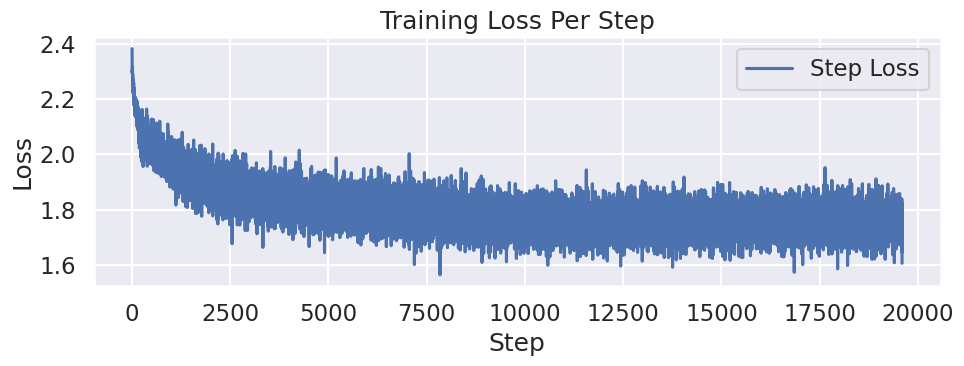

In [19]:
sns.set_theme()
sns.set_context("talk")
plt.figure(figsize=(10, 4))
plt.plot(train_loss_per_step, label="Step Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Per Step")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

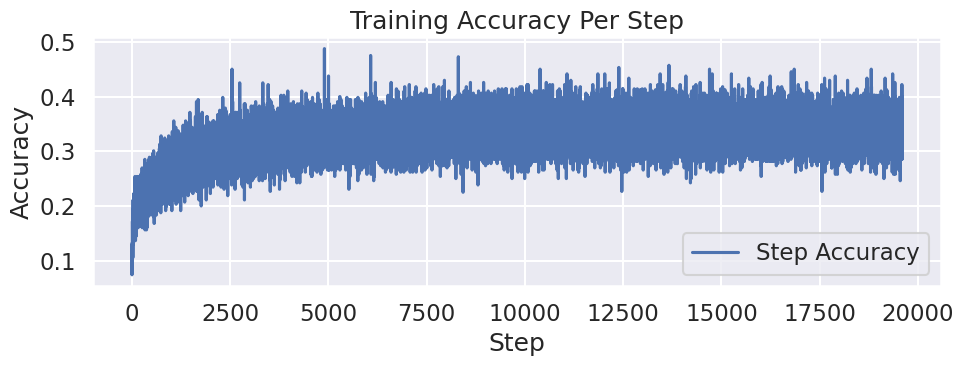

In [20]:
sns.set_theme()
sns.set_context("talk")
plt.figure(figsize=(10, 4))
plt.plot(train_acc_per_step, label="Step Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Per Step")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()

4.Visualization

4.1Visualize Training Results

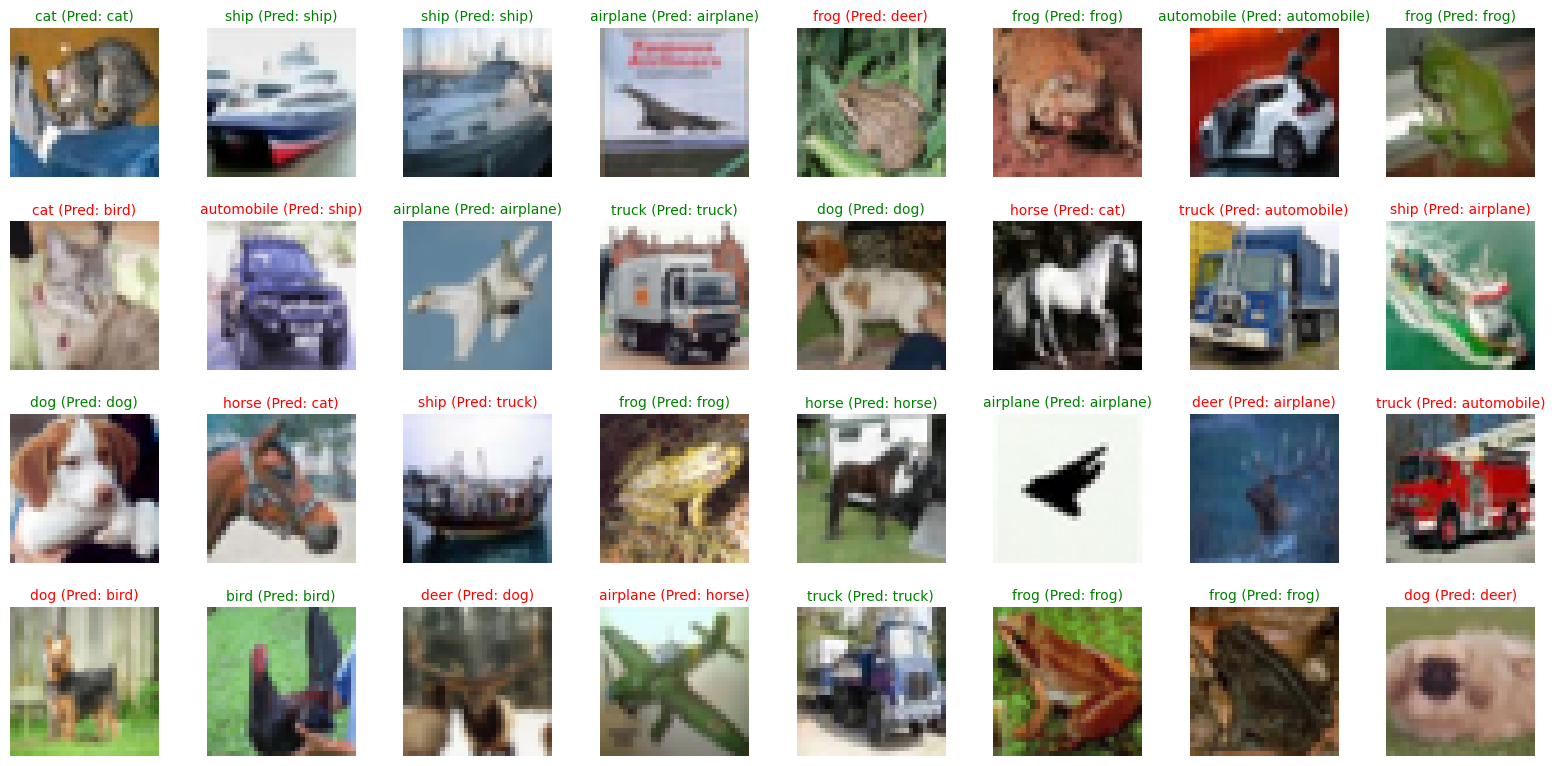

In [21]:
N_ROWS = 4
N_COLS = 8
N_IMGS = N_ROWS * N_COLS
test_dataset = torchvision.datasets.CIFAR10(
    root=train_config.data_dir,
    download=True,
    train=False,
)
IDX_TO_CLASS = {v: k for k, v in test_dataset.class_to_idx.items()}

org_imgs, true_labels = test_dataset.data[:N_IMGS], test_dataset.targets[:N_IMGS]
transformed_imgs = torch.stack([data_transform(Image.fromarray(img)) for img in org_imgs])
pred_labels = model(tensor_to_device(transformed_imgs, device=train_config.device)).argmax(dim=1).cpu()


fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 2, N_ROWS * 2))
for i in range(N_ROWS):
    for j in range(N_COLS):
        idx = i * N_COLS + j
        axes[i, j].imshow(org_imgs[idx])
        axes[i, j].axis("off")
        if true_labels[idx] == pred_labels[idx].item():
            axes[i, j].set_title(
                f"{IDX_TO_CLASS[true_labels[idx]]} (Pred: {IDX_TO_CLASS[pred_labels[idx].item()]})",
                fontsize=10,
                color="green",
            )
        else:
            axes[i, j].set_title(
                f"{IDX_TO_CLASS[true_labels[idx]]} (Pred: {IDX_TO_CLASS[pred_labels[idx].item()]})",
                fontsize=10,
                color="red",
            )
plt.tight_layout()
plt.show()

In [ ]:
4.2Visualize Attention Maps

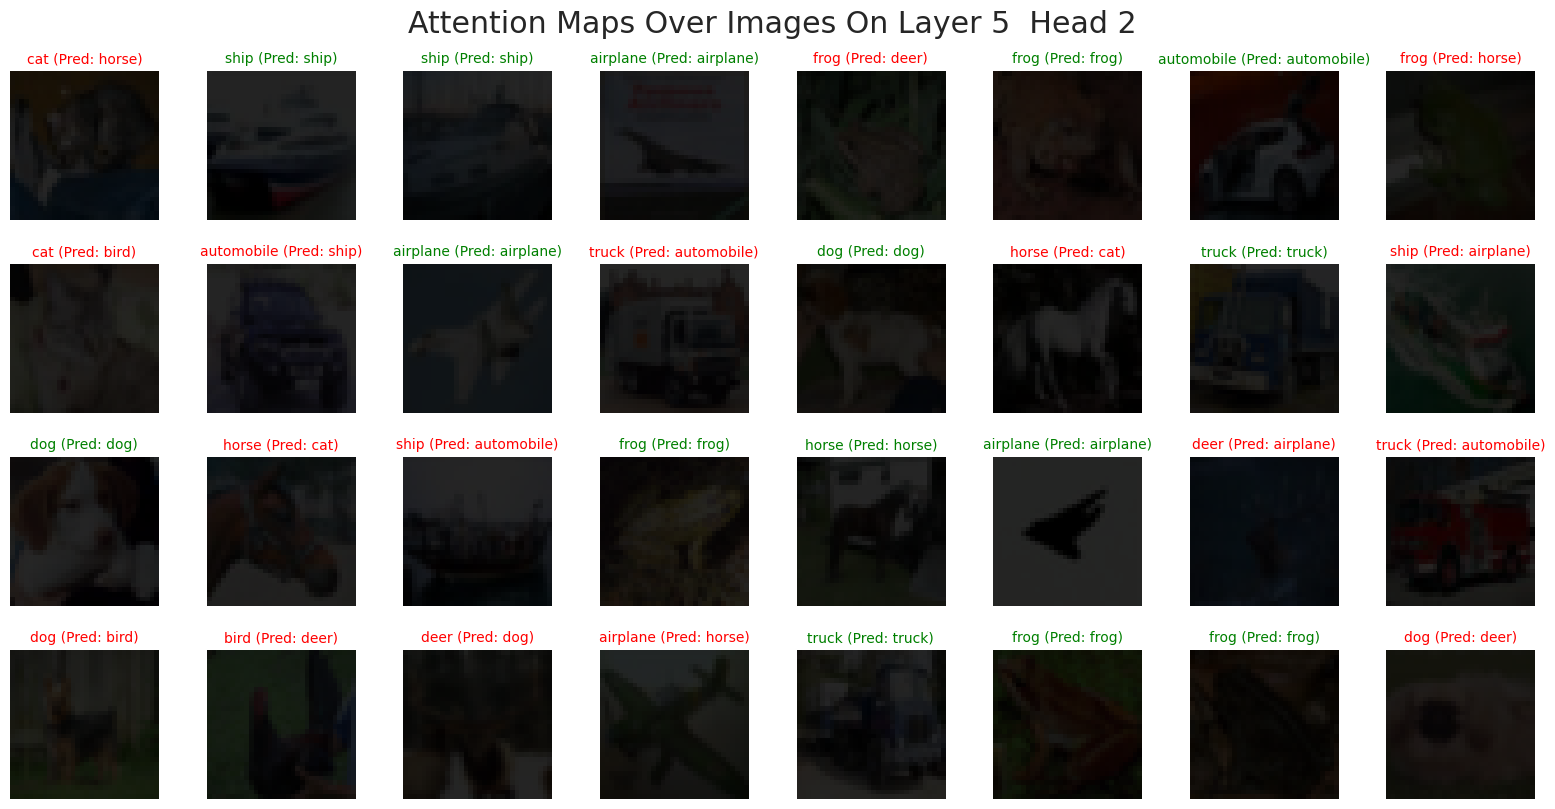

In [23]:
N_ROWS = 4
N_COLS = 8
N_IMGS = N_ROWS * N_COLS
test_dataset = torchvision.datasets.CIFAR10(
    root=train_config.data_dir,
    download=True,
    train=False,
)
IDX_TO_CLASS = {v: k for k, v in test_dataset.class_to_idx.items()}

org_imgs, true_labels = test_dataset.data[:N_IMGS], test_dataset.targets[:N_IMGS]
transformed_imgs = torch.stack([data_transform(Image.fromarray(img)) for img in org_imgs]).to(
    train_config.device
)

# pred_labels = model(tensor_to_device(transformed_imgs, device=train_config.device)).argmax(dim=1).cpu()
TARGET_LAYER = 5  # 0-based index
HEAD = 2
GAMMA = 0.7
FLOOR = 0.15


def to_vit_attention_vis(img_uint8, attn_map, gamma=0.7, floor=0.15):
    """
    gamma:     >0, smaller -> sharper spotlight
    floor:     how visible the dark region is (0 = pure black background)
    """
    img = img_uint8.astype(np.float32) / 255.0

    # normalize attention to [0,1]
    a = attn_map.astype(np.float32)
    a = a - a.min()
    a = a / (a.max() + 1e-6)

    # make it more "spotlight-like"
    a = a**gamma  # sharpen
    a = floor + (1 - floor) * a  # keep some visibility outside
    a = np.clip(a, 0, 1)

    return img * a[..., None]  # darken outside attention


model.eval()
x = model.backbone.patch_embedder(transformed_imgs)
x = model.backbone.pos_embedder(x)
for i in range(TARGET_LAYER):
    x = model.backbone.encoder_layers[i](x)

_, attn_weights = model.backbone.encoder_layers[TARGET_LAYER].mha(
    model.backbone.encoder_layers[TARGET_LAYER].norm1(x)
)
if HEAD >= 0:
    attn_weights = attn_weights[:, HEAD, 0, 1:]  # (B, N)
else:
    attn_weights = attn_weights.mean(dim=1)[:, 0, 1:]  # (B, N)

# Reshape attention weights to (B, H, W)
num_patches_per_side = model_config.image_size // model_config.patch_size
attn_maps = attn_weights.reshape(-1, num_patches_per_side, num_patches_per_side)  # (B, H, W)

# Upsample attention maps to image size
attn_maps_upsampled = F.interpolate(
    attn_maps.unsqueeze(1),
    size=(model_config.image_size, model_config.image_size),
    mode="bilinear",
    align_corners=False,
).squeeze(1)  # (B, H, W)

# Move attention map to CPU for visualization
attn_maps_upsampled = attn_maps_upsampled.cpu().detach().numpy()

# Visualize Overlaid Attention Maps
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 2, N_ROWS * 2))
for i in range(N_ROWS):
    for j in range(N_COLS):
        idx = i * N_COLS + j
        vis = to_vit_attention_vis(
            org_imgs[idx],
            attn_maps_upsampled[idx],
            gamma=GAMMA,
            floor=FLOOR,
        )

        axes[i, j].imshow(vis)
        axes[i, j].axis("off")
        if true_labels[idx] == pred_labels[idx].item():
            axes[i, j].set_title(
                f"{IDX_TO_CLASS[true_labels[idx]]} (Pred: {IDX_TO_CLASS[pred_labels[idx].item()]})",
                fontsize=10,
                color="green",
            )
        else:
            axes[i, j].set_title(
                f"{IDX_TO_CLASS[true_labels[idx]]} (Pred: {IDX_TO_CLASS[pred_labels[idx].item()]})",
                fontsize=10,
                color="red",
            )
plt.tight_layout()
plt.suptitle(
    f"Attention Maps Over Images On Layer {TARGET_LAYER}  {'Head ' + str(HEAD) if HEAD >= 0 else 'Avg Head'}",
    y=1.02,
)
plt.show()